# Data Preparation - Duque de Caxias

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy.stats import pearsonr
import readHistData as hist

## 1. Load Observed Data from CSV

In [2]:
df = pd.read_csv('../data/DuqueCaxias.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 12 rows of data


,ADT_Bilac,ADT_Primavera,ADT_Saracuruna,OVT_Bilac,OVT_Primavera,OVT_Saracuruna,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,0.100418,0.058577,0.044643,36.731092,28.752212,33.057143,2009_11,45.125,21.735119,23.678571,26.072024
1,0.049107,0.079498,0.042373,56.452174,56.771930,42.417910,2009_12,48.775,22.727679,24.984821,27.656250
2,0.141667,0.164557,0.075314,85.807018,131.276786,57.148148,2010_01,21.750,23.648810,26.288095,29.339881
3,0.160338,0.183246,0.050209,80.188034,73.793103,59.451327,2010_02,55.875,23.476190,26.802381,30.737500
4,0.050000,0.108333,0.046218,45.628319,64.025641,53.928571,2010_03,53.600,23.432143,26.238750,29.238036


In [3]:
days = [i * 30 for i in range(len(df))]

BilacOVT = df['OVT_Bilac'].ffill().bfill().values
PrimaveraOVT = df['OVT_Primavera'].ffill().bfill().values
SaracurunaOVT = df['OVT_Saracuruna'].ffill().bfill().values

BilacADT = df['ADT_Bilac'].ffill().bfill().values
PrimaveraADT = df['ADT_Primavera'].ffill().bfill().values
SaracurunaADT = df['ADT_Saracuruna'].ffill().bfill().values

print(f"Days: {days}")
print(f"Number of time points: {len(days)}")

Days: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
Number of time points: 12


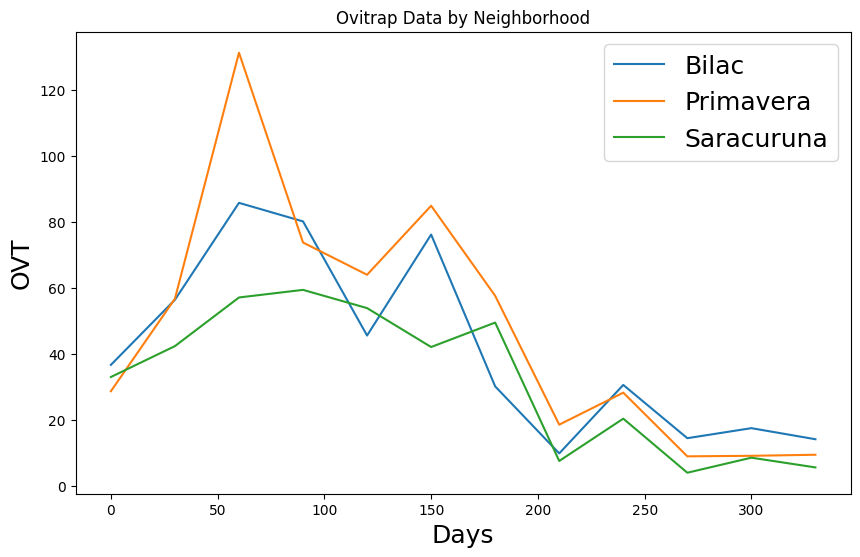

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(days, BilacOVT, label='Bilac')
plt.plot(days, PrimaveraOVT, label='Primavera')
plt.plot(days, SaracurunaOVT, label='Saracuruna')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("Ovitrap Data by Neighborhood")
plt.show()

## 2. Extract Terrain Proportions from Maps

In [5]:
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50:
        return True
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:
            return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    step = 3
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            if isWater(pixel_map):
                water += 1
            elif isStreet(pixel_map):
                streets += 1
            elif isGreen(pixel_sat):
                parks += 1
            else:
                houses += 1
    return [water, parks, streets, houses]

In [6]:
neighborhoods = ['Bilac', 'Primavera', 'Saracuruna']
map_base_path = '../maps/DuqueDeCaxias_RJ'

proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

Processing Bilac...
  Raw counts [water, parks, streets, houses]: [0, 3278, 31286, 147765]
Processing Primavera...
  Raw counts [water, parks, streets, houses]: [0, 25312, 17831, 139186]
Processing Saracuruna...
  Raw counts [water, parks, streets, houses]: [0, 14567, 25496, 142266]


In [7]:
proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")
print("\nProportions Matrix:")
print(matProporcoes)

Proportions [water, parks, streets, houses]:
  Bilac: water=0.0000, parks=0.0180, streets=0.1716, houses=0.8104
  Primavera: water=0.0000, parks=0.1388, streets=0.0978, houses=0.7634
  Saracuruna: water=0.0000, parks=0.0799, streets=0.1398, houses=0.7803

Proportions Matrix:
[[0.         0.01797849 0.17159092 0.8104306 ]
 [0.         0.13882597 0.09779574 0.76337829]
 [0.         0.07989404 0.13983513 0.78027083]]


## 3. Decompose OVT Data

In [8]:
O_agua, O_parque, O_rua, O_casa = [], [], [], []
OVT_data = [BilacOVT, PrimaveraOVT, SaracurunaOVT]

for t in range(len(days)):
    vetOvo = [OVT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua, O_parque, O_rua, O_casa = np.array(O_agua), np.array(O_parque), np.array(O_rua), np.array(O_casa)
print("OVT decomposition complete.")

OVT decomposition complete.


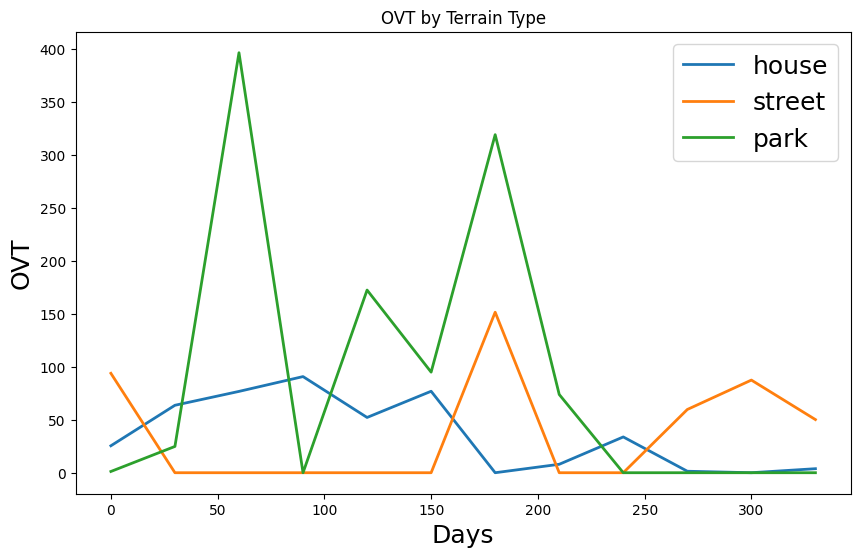

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data

In [10]:
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []
ADT_data = [BilacADT, PrimaveraADT, SaracurunaADT]

for t in range(len(days)):
    vetAdt = [ADT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua, ADT_parque, ADT_rua, ADT_casa = np.array(ADT_agua), np.array(ADT_parque), np.array(ADT_rua), np.array(ADT_casa)
print("ADT decomposition complete.")

ADT decomposition complete.


## 5. Validate Reconstruction

In [11]:
reconstructed_OVT = [np.zeros(len(days)) for _ in range(3)]
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    for i in range(3):
        reconstructed_OVT[i][t] = R[0, i]

print("Reconstruction Correlations (OVT):")
for i, name in enumerate(neighborhoods):
    corr = pearsonr(reconstructed_OVT[i], OVT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (OVT):
  Bilac: 0.9894
  Primavera: 0.9943
  Saracuruna: 0.9305


## 6. Save Results

In [12]:
data_new = {
    "Day": days,
    "OVT_house": O_casa,
    "OVT_park": O_parque,
    "OVT_street": O_rua,
    "ADT_house": ADT_casa,
    "ADT_park": ADT_parque,
    "ADT_street": ADT_rua,
    "Temperature": [hist.temperature(t) for t in days],
    "Pluviosity": [hist.pluviosity(t) for t in days]
}

df_new = pd.DataFrame(data_new)
df_new.to_csv("dataNew.csv", index=False)
print("Saved dataNew.csv")
df_new.head(10)

Saved dataNew.csv


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,25.431067,1.172595,93.827205,0.000000,0.000000,0.498659,23.6785714286,45.125
1,30,63.650332,24.809467,0.000000,0.046010,0.265213,0.000000,24.984821428575003,48.77499999999999
2,60,76.745497,396.377780,0.000000,0.139215,0.228973,0.000000,26.288095238075,21.75
3,90,90.732552,0.000000,0.000000,0.163587,0.086357,0.006784,26.80238095235,55.875
4,120,52.157169,172.389822,0.000000,0.037594,0.490998,0.000000,26.23875,53.599999999999994
5,150,76.886446,94.927447,0.000000,0.105588,0.905114,0.000000,24.49285714285,42.675
6,180,0.000000,319.037011,151.488677,0.164303,0.474133,0.000000,23.830833333324996,2.450000000000003
7,210,7.958553,73.844292,0.000000,0.123135,0.294757,0.000000,21.5220238095,8.65
8,240,33.771362,0.000000,0.000000,0.073665,0.164225,0.000000,21.30785714285,0.0
9,270,1.396015,0.000000,59.686692,0.038667,0.250064,0.000000,21.05535714285,0.0
